### BRIAN, THE STITCH, AND THE WARDROBE
Imagine that on the floor in front of you is a pile of all
the clothing you own—trousers, tops, shoes, and coats,
all of different styles. Your stylist, Brian, is becoming
increasingly frustrated with how long it takes him to
find the items you require, so he devises a clever plan.
He tells you to organize your clothes into a wardrobe
that is infinitely high and wide (Figure 3-1). When you
want to request a particular item, you simply need to
tell Brian its location and he will sew the item from
scratch using his trusty sewing machine. It soon
becomes obvious that you will need to place similar
items near to each other, so that Brian can accurately
re-create each item given only its location.

After several weeks of practice, you and Brian have
adjusted to each other’s understandings of the wardrobe
layout. It is now possible for you to tell Brian the location of any item of clothing that you desire, and he
can accurately sew it from scratch!
This gives you an idea—what would happen if you gave
Brian a wardrobe location that was empty? To your
amazement, you find that Brian is able to generate
entirely new items of clothing that haven’t existed
before! The process isn’t perfect, but you now have
limitless options for generating new clothing, just by
picking an empty location in the infinite wardrobe and
letting Brian work his magic with the sewing machine.


In [1]:
import numpy as np

In [2]:
from tensorflow.keras import datasets
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

In [3]:
def preprocess(imgs):
    imgs = imgs.astype('float32')/255.0
    imgs = np.pad(imgs, ((0,0),(2,2),(2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs


In [4]:
print(x_train.shape)
x_train = preprocess(x_train)
x_test = preprocess(x_test)
print(x_train.shape)

(60000, 28, 28)
(60000, 32, 32, 1)


An autoencoder is a neural network made up of two parts:
- An encoder network that compresses high-dimensional
input data such as an image into a lower-dimensional
embedding vector
- A decoder network that decompresses a given
embedding vector back to the original domain (e.g.,
back to an image)

#### Encoder

In [5]:
from tensorflow.keras import layers,models
import keras.backend as K 

In [6]:
encoder_input = layers.Input(shape=(32,32,1),name='encoder_input')
x = layers.Conv2D(filters=32
                  ,kernel_size=3
                  ,strides=2
                  ,activation='relu'
                  ,padding='same')(encoder_input)
x = layers.Conv2D(filters=64
                  ,kernel_size=3
                  ,strides=2
                  ,activation='relu'
                  ,padding='same')(x)
x = layers.Conv2D(filters=128
                  ,kernel_size=3
                  ,strides=2
                  ,activation='relu'
                  ,padding='same')(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(units=2,name='encoder_output')(x)
model = models.Model(encoder_input,encoder_output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

### Decoder

The convolutional transpose layer uses the same
principle as a standard convolutional layer (passing a
filter across the image), but is different in that setting
strides = 2 doubles the size of the input tensor in both
dimensions

In [7]:
decoder_input = layers.Input(shape=(2,), name='decoder_input')
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128,(3,3)
    ,strides=2
    ,activation='relu'
    ,padding='same'
)(x)

x = layers.Conv2DTranspose(
    64,(3,3)
    ,strides=2
    ,activation='relu'
    ,padding='same'
)(x)

x = layers.Conv2DTranspose(
    32,(3,3)
    ,strides=2
    ,activation='relu'
    ,padding='same'
)(x)

decoder_output = layers.Conv2D(
    1,(3,3)
    ,strides=1
    ,activation='sigmoid'
    ,padding='same'
    ,name='decoder_output'
)(x)
decoder = models.Model(decoder_input, decoder_output)

In [8]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
autoencoder.fit(
    x_train
    ,x_train
    ,epochs=5
    ,batch_size=100
    ,shuffle=True
    ,validation_data=(x_test,x_test)
)

Epoch 1/5
600/600 [==============================] - 24s 22ms/step - loss: 0.2939 - val_loss: 0.2615
Epoch 2/5
600/600 [==============================] - 12s 20ms/step - loss: 0.2571 - val_loss: 0.2562
Epoch 3/5
600/600 [==============================] - 12s 20ms/step - loss: 0.2535 - val_loss: 0.2539
Epoch 4/5
600/600 [==============================] - 12s 19ms/step - loss: 0.2516 - val_loss: 0.2519
Epoch 5/5
600/600 [==============================] - 12s 20ms/step - loss: 0.2503 - val_loss: 0.2509


#### Reconstructing Images

In [10]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [11]:
example_images = x_test[:5000]

157/157 [==============================] - 4s 3ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


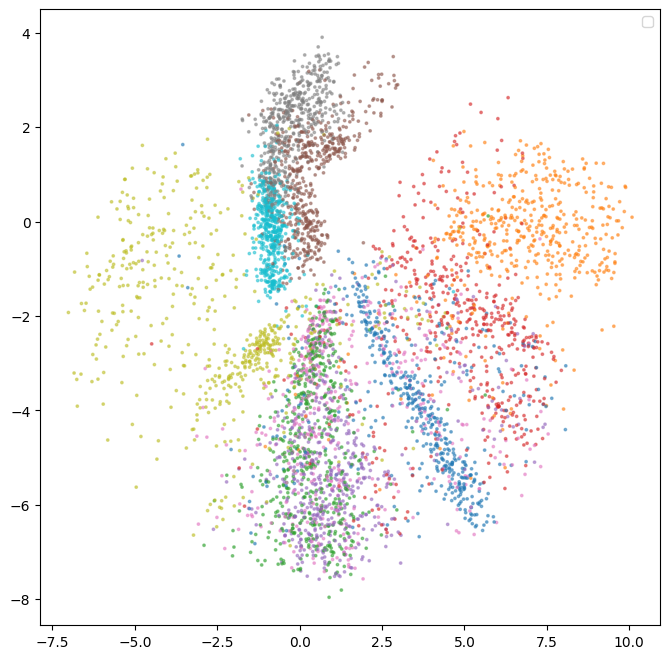

In [12]:
import matplotlib.pyplot as plt
embeddings = model.predict(example_images)
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0],embeddings[:,1], c=np.choose(y_test[:5000],colors), alpha=0.5,s=3)
plt.legend()
plt.show()


In [13]:
mins,maxs = np.min(embeddings,axis=0),np.max(embeddings,axis=0)
sample = np.random.uniform(mins,maxs,size=(18,2))
reconstructions = decoder.predict(sample)

1/1 [==============================] - 4s 4s/step


In [14]:
reconstructions[1].reshape((32,32)).shape

(32, 32)

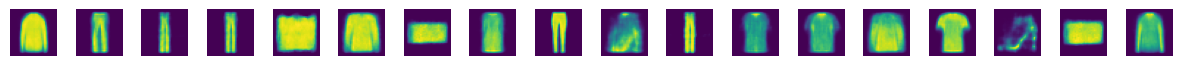

In [15]:
n_to_show=sample.shape[0]
fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

for i,idx in enumerate(range(sample.shape[0])):
    img= reconstructions[i].reshape((32,32))
    ax = fig.add_subplot(1,n_to_show,i+1)
    ax.axis('off')
    ax.imshow(img)

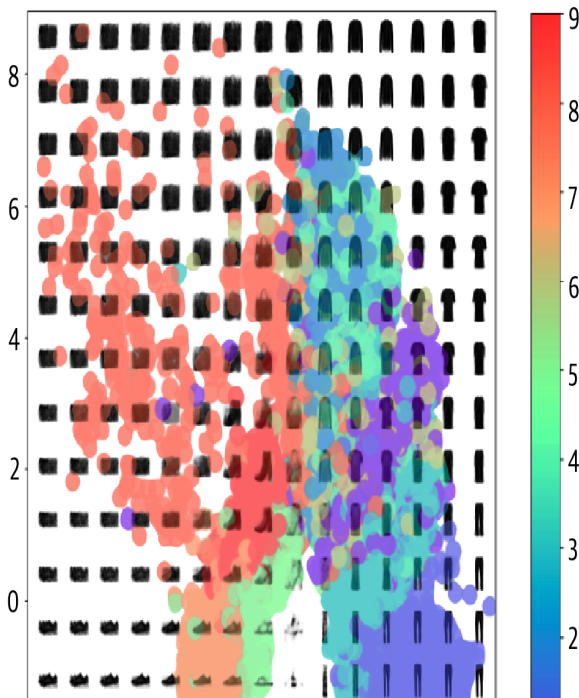
- Some clothing items are represented over a very small
area and others over a much larger area.
- The distribution is not symmetrical about the point (0,
0), or bounded. For example, there are far more points
with positive y-axis values than negative, and some
points even extend to a y-axis value > 8.
- There are large gaps between colors containing few
points.

- Firstly, we can see that if we pick points uniformly in a
bounded space that we define, we’re more likely to sample
something that decodes to look like a bag (ID 8) than an
ankle boot (ID 9) because the part of the latent space
carved out for bags (orange) is larger than the ankle boot
area (red).
- Secondly, it is not obvious how we should go about
choosing a random point in the latent space, since the
distribution of these points is undefined. Technically, we
would be justified in choosing any point in the 2D plane!
It’s not even guaranteed that points will be centered
around (0, 0). This makes sampling from our latent space
problematic.
- Lastly, we can see holes in the latent space where none of
the original images are encoded. For example, there are
large white spaces at the edges of the domain—the
autoencoder has no reason to ensure that points here are
decoded to recognizable clothing items as very few images
in the training set are encoded here.

In two dimensions this issue is subtle; the autoencoder only
has a small number of dimensions to work with, so
naturally it has to squash clothing groups together,
resulting in the space between clothing groups being
relatively small. However, as we start to use more
dimensions in the latent space to generate more complex
images such as faces, this problem becomes even more
apparent. If we give the autoencoder free rein over how it
uses the latent space to encode images, there will be huge
gaps between groups of similar points with no incentive for
the spaces in between to generate well-formed images.

### Variational Autoencoders

**REVISITING THE INFINITE WARDROBE**

Suppose now, instead of placing every item of clothing
at a single point in the wardrobe, you decide to allocate
a general area where the item is more likely to be found.
You reason that this more relaxed approach to item
location will help to solve the current issue around local
discontinuities in the wardrobe.

Also, in order to ensure you do not become too careless
with the new placement system, you agree with Brian
that you will try to place the center of each item’s area
as close to the middle of the wardrobe as possible and
that deviation of the item from the center should be as
close to one meter as possible (not smaller and not
larger). The further you stray from this rule, the more
you have to pay Brian as your stylist.

After several months of operating with these two simple
changes, you step back and admire the new wardrobe
layout, alongside some examples of new clothing items
that Brian has generated. Much better! There is plenty
of diversity in the generated items, and this time there
are no examples of poor-quality garments. It seems the
two changes have made all the difference!


#### Modifications to the encoder
In an autoencoder, each image is mapped directly to one
point in the latent space. In a variational autoencoder, each
image is instead mapped to a multivariate normal
distribution around a point in the latent space

A multivariate standard normal distribution N (0, I) is a
multivariate distribution with a zero-valued mean vector
and identity covariance matrix

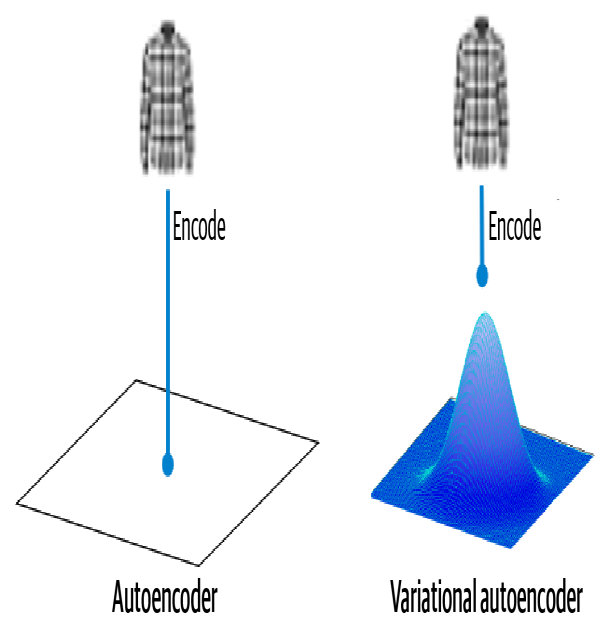

To summarize, the encoder will take each input image and
encode it to two vectors that together define a multivariate
normal distribution in the latent space.

We can sample a point z from the distribution defined by
these values using the following equation:

z = z_mean + z_sigma * epsilon

First, we need to create a new type of Sampling layer that
will allow us to sample from the distribution defined by
z_mean and z_log_var

In [16]:
import tensorflow as tf 
import keras.backend as K

In [17]:
class Sampling(layers.Layer):
    def call(self,inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]  
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [18]:
encoder_input = layers.Input(
    shape=(32,32,1), name='encoder_input'
)
x = layers.Conv2D(32, (3,3), strides=2,activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2,activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3,3), strides=2,activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name='z_mean')(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean,z_log_var,z],name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_4 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_4[0][0]']               
                                                                                            

#### The Loss Function

Previously, our loss function only consisted of the
reconstruction loss between images and their attempted
copies after being passed through the encoder and
decoder. 

The reconstruction loss also appears in a
variational autoencoder, but we now require one extra
component: the Kullback–Leibler (KL) divergence term.

**KL divergence** is a way of measuring how much one
probability distribution differs from another. In a VAE, we
want to measure how much our normal distribution with
parameters z_mean and z_log_var differs from a standard
normal distribution

kl_loss = -0.5 * sum(1 + z_log_var - z_mean ^ 2 - exp(z_log_var))

In [19]:
from tensorflow.keras import metrics,losses

In [20]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstrunction_loss_tracker = metrics.Mean(
            name='reconstruction_loss'
        )
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstrunction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def call(self,inputs):
        z_mean, z_log_var,z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self,data):
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500*losses.binary_crossentropy(
                data,reconstruction, axis=(1,2,3)
            ))
            kl_loss =tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstrunction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {m.name: m.result() for m in self.metrics}

TensorFlow’s Gradient Tape is a mechanism that allows the
computation of gradients of operations executed during a forward
pass of a model. To use it, you need to wrap the code that performs
the operations you want to differentiate in a tf.GradientTape()
context. Once you have recorded the operations, you can compute
the gradient of the loss function with respect to some variables by
calling tape.gradient().

In [21]:
vae = VAE(encoder,decoder)
vae.compile(optimizer='adam')
vae.fit(
    x_train,
    epochs=5,
    batch_size=100
)

Epoch 1/5
600/600 [==============================] - 14s 15ms/step - total_loss: 141.2549 - reconstruction_loss: 136.0637 - kl_loss: 5.1912
Epoch 2/5
600/600 [==============================] - 9s 15ms/step - total_loss: 132.3434 - reconstruction_loss: 127.1088 - kl_loss: 5.2345
Epoch 3/5
600/600 [==============================] - 9s 15ms/step - total_loss: 131.5898 - reconstruction_loss: 126.3055 - kl_loss: 5.2843
Epoch 4/5
600/600 [==============================] - 10s 16ms/step - total_loss: 131.0703 - reconstruction_loss: 125.7640 - kl_loss: 5.3062
Epoch 5/5
600/600 [==============================] - 12s 19ms/step - total_loss: 130.6209 - reconstruction_loss: 125.2863 - kl_loss: 5.3346


In [22]:
from utils import display

In [23]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 7s 5ms/step
Example real clothing items


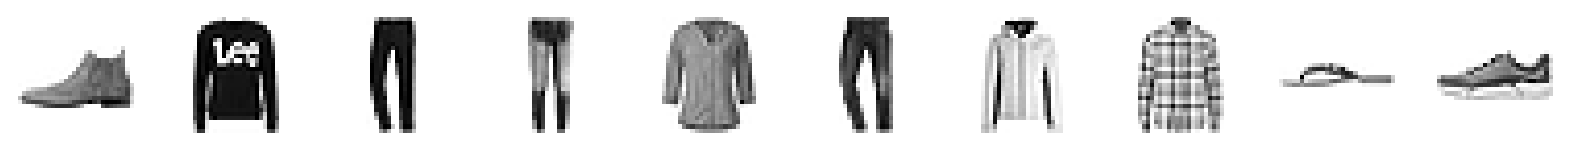

Reconstructions


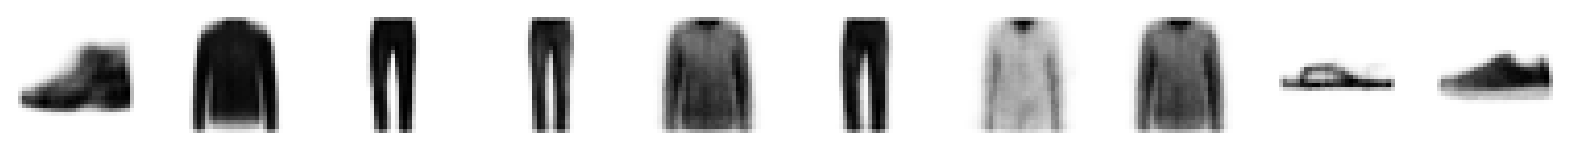

In [24]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 5s 3ms/step


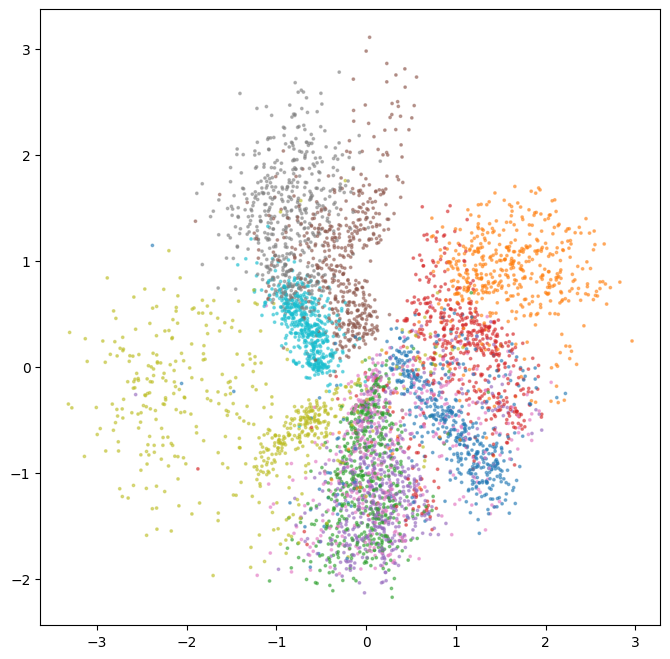

In [25]:
# Show the encoded points in 2D space
figsize = 8
z_mean, z_var, z = encoder.predict(example_images)


plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c=np.choose(y_test[:5000],colors), alpha=0.5, s=3)
plt.show()

In [26]:
folder = 'C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\celeba\\img_align_celeba\\img_align_celeba\\img_align_celeba'

In [27]:
from tensorflow.keras import utils

In [28]:
train_data = utils.image_dataset_from_directory(
                                        folder
                                        ,labels=None
                                        ,color_mode='rgb'
                                        ,image_size=(64,64)
                                        ,batch_size=128
                                        ,shuffle=True
                                        ,seed=42
                                        ,interpolation='bilinear'
                                        )

Found 202599 files belonging to 1 classes.


In [29]:
def preprocess(img):
    img = tf.cast(img,'float32') / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))



### Training the Variational Autoencoder
The network architecture for the faces model is similar to
the Fashion-MNIST example, with a few slight differences:
- Our data now has three input channels (RGB) instead
of one (grayscale). This means we need to change the
number of channels in the final convolutional transpose
layer of the decoder to 3.
- We shall be using a latent space with 200 dimensions
instead of 2. Since faces are much more complex than
the Fashion-MNIST images, we increase the
dimensionality of the latent space so that the network
can encode a satisfactory amount of detail from the
images.
- There are batch normalization layers after each
convolutional layer to stabilize training. Even though
each batch takes a longer time to run, the number of
batches required to reach the same loss is greatly
reduced.
- We increase the β factor for the KL divergence to
2,000. This is a parameter that requires tuning; for this
dataset and architecture this value was found to
generate good results.


#### Encoder

In [30]:
from utils import sample_batch, display
train_sample = sample_batch(train)

In [31]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [32]:
encoder_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS), name='encoder_input')
x = layers.Conv2D( filters=NUM_FEATURES, kernel_size=3, strides=2, padding='same')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D( filters=NUM_FEATURES, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D( filters=NUM_FEATURES, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D( filters=NUM_FEATURES, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D( filters=NUM_FEATURES, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name='z_mean')(x)
z_log_var = layers.Dense(Z_DIM, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input,[z_mean,z_log_var,z],name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 64)   1792        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d_6[0][0]']               
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]

#### Decoder

In [33]:
decoder_input = layers.Input(shape=(Z_DIM,),name='decoder_input')
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(NUM_FEATURES,kernel_size=3,strides=2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2DTranspose(CHANNELS,kernel_size=3,strides=1,activation='sigmoid',
                                        padding='same')(x)

decoder = models.Model(decoder_input,decoder_output)
decoder.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 256)               51456     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 4, 4, 64)         36928     
 ranspose)                                                 

In [34]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [37]:
from tensorflow.keras import optimizers, callbacks

In [38]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)


In [39]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [41]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10


1583/1583 [==============================] - ETA: 0s - loss: 71.4033 - reconstruction_loss: 54.6377 - kl_loss: 15.4888

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 198s 120ms/step - loss: 71.4025 - reconstruction_loss: 54.6377 - kl_loss: 15.4888
Epoch 2/10
1583/1583 [==============================] - ETA: 0s - loss: 68.1491 - reconstruction_loss: 51.8787 - kl_loss: 15.9321

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 182s 111ms/step - loss: 68.1489 - reconstruction_loss: 51.8787 - kl_loss: 15.9321
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 67.1111 - reconstruction_loss: 50.7735 - kl_loss: 16.0607

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 157s 96ms/step - loss: 67.1110 - reconstruction_loss: 50.7735 - kl_loss: 16.0607
Epoch 4/10
1583/1583 [==============================] - ETA: 0s - loss: 66.1716 - reconstruction_loss: 49.5675 - kl_loss: 16.3443

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 154s 94ms/step - loss: 66.1714 - reconstruction_loss: 49.5675 - kl_loss: 16.3443
Epoch 5/10
1583/1583 [==============================] - ETA: 0s - loss: 65.5593 - reconstruction_loss: 48.8538 - kl_loss: 16.5268

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 152s 93ms/step - loss: 65.5592 - reconstruction_loss: 48.8538 - kl_loss: 16.5268
Epoch 6/10
1583/1583 [==============================] - ETA: 0s - loss: 65.1146 - reconstruction_loss: 48.2603 - kl_loss: 16.7176

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 155s 95ms/step - loss: 65.1145 - reconstruction_loss: 48.2603 - kl_loss: 16.7176
Epoch 7/10
1583/1583 [==============================] - ETA: 0s - loss: 64.8274 - reconstruction_loss: 47.8401 - kl_loss: 16.8567

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 160s 98ms/step - loss: 64.8273 - reconstruction_loss: 47.8401 - kl_loss: 16.8567
Epoch 8/10
1583/1583 [==============================] - ETA: 0s - loss: 64.6063 - reconstruction_loss: 47.5705 - kl_loss: 16.9091

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 154s 94ms/step - loss: 64.6062 - reconstruction_loss: 47.5705 - kl_loss: 16.9091
Epoch 9/10
1583/1583 [==============================] - ETA: 0s - loss: 64.4051 - reconstruction_loss: 47.3594 - kl_loss: 16.9671

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 156s 95ms/step - loss: 64.4051 - reconstruction_loss: 47.3594 - kl_loss: 16.9671
Epoch 10/10
1583/1583 [==============================] - ETA: 0s - loss: 64.2326 - reconstruction_loss: 47.1055 - kl_loss: 17.0527

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1583/1583 [==============================] - 213s 131ms/step - loss: 64.2326 - reconstruction_loss: 47.1055 - kl_loss: 17.0527


In [42]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


#### Reconstruction of new samples

1/1 [==============================] - 4s 4s/step


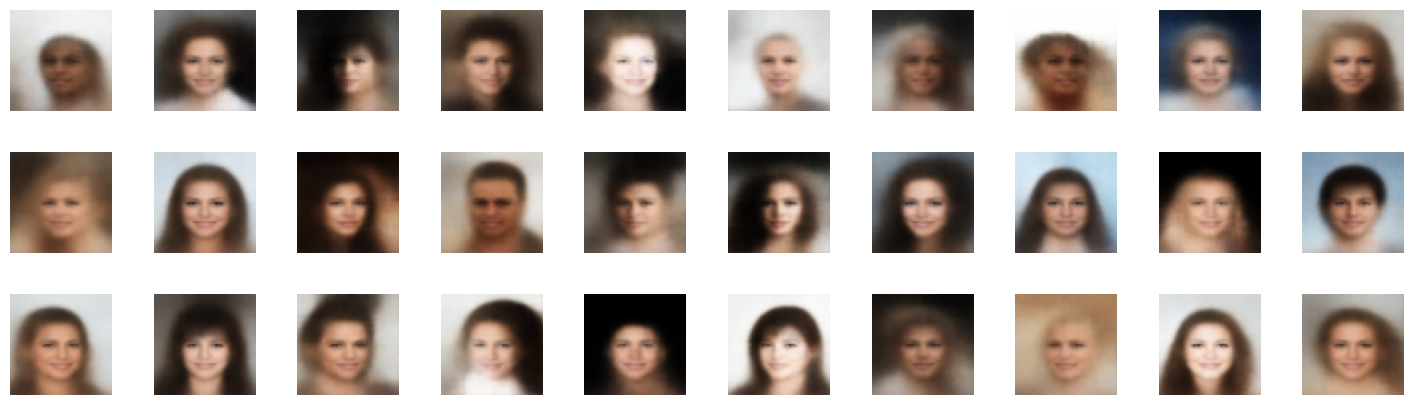

In [43]:
grid_width, grid_height = (10,3)
z_sample = np.random.normal(size=(grid_width * grid_height,Z_DIM))
reconstructions = decoder.predict(z_sample)

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height,grid_width,i+1)
    ax.axis('off')
    ax.imshow(reconstructions[i,:,:])

In [ ]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

#### Latent Space Arithmetic

Conceptually, we are performing the following vector
arithmetic in the latent space, where alpha is a factor that
determines how much of the feature vector is added or
subtracted:

z_new = z + alpha * feature_vector


In [44]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 5s 14ms/step
Example real faces


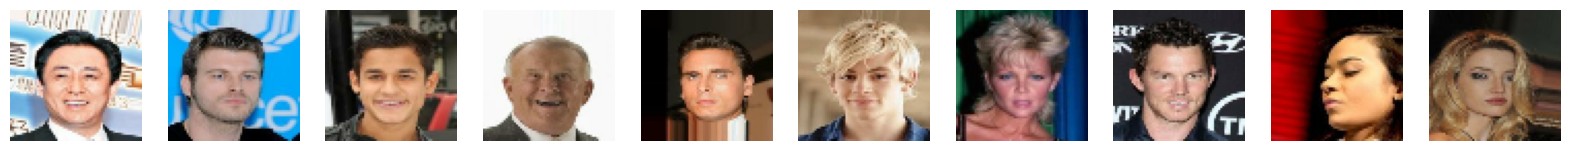

Reconstructions


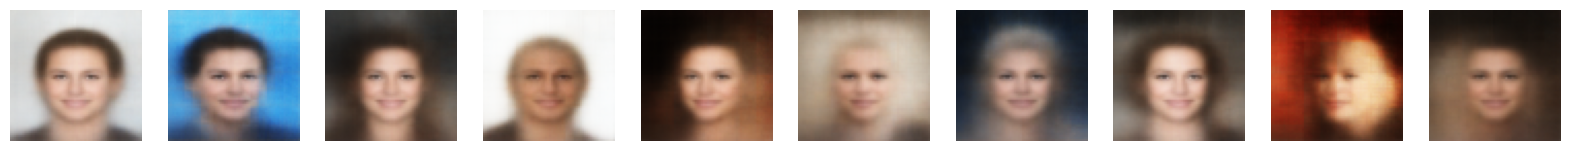

In [45]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

In [47]:
from scipy.stats import norm


4/4 [==============================] - 4s 5ms/step


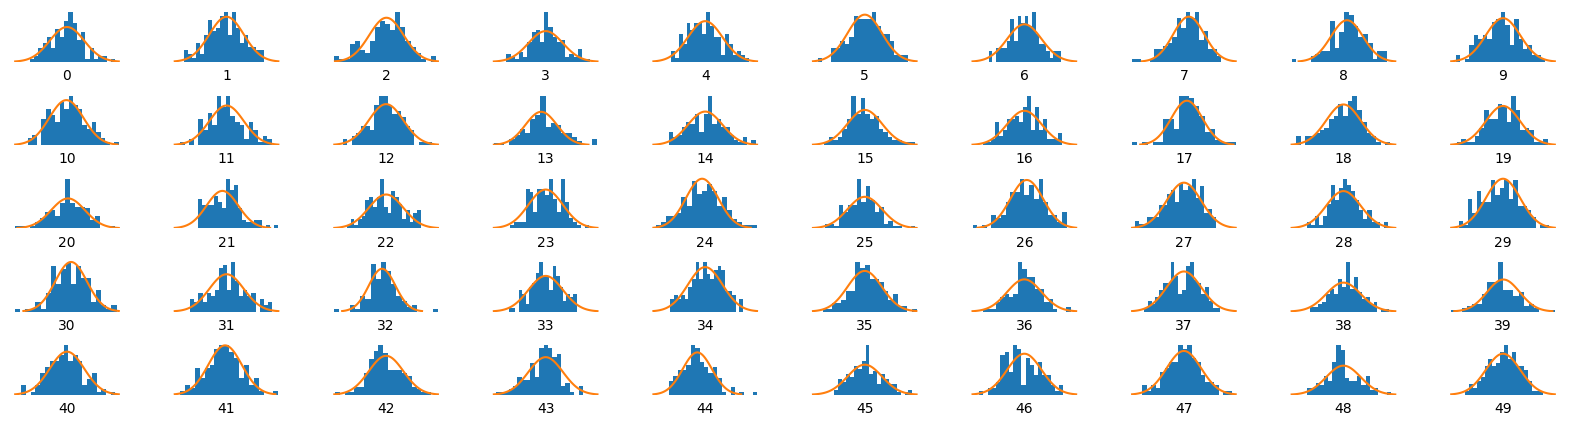

In [48]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

In [49]:
import pandas as pd

In [51]:
attributes = pd.read_csv('C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\celeba\\img_align_celeba\\list_attr_celeba.csv')
print(attributes.columns)
attributes.head()


Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [57]:
folder

'C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\celeba\\img_align_celeba\\img_align_celeba\\img_align_celeba'

In [61]:
LABEL = 'Blond_Hair'
labelled_test = utils.image_dataset_from_directory(
    'C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\celeba\\img_align_celeba\\img_align_celeba'
    ,labels = attributes[LABEL].tolist()
    ,color_mode='rgb'
    ,image_size=(IMAGE_SIZE,IMAGE_SIZE)
    ,batch_size=BATCH_SIZE
    ,shuffle=True
    ,seed=42
    ,validation_split=0.2
    ,subset='validation'
    ,interpolation='bilinear'
)

labelled = labelled_test.map(lambda x,y: (preprocess(x),y))

Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [62]:
from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces


In [63]:
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM,LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.181    : 1.338    : 3.523    : 3.523
44    : 2.08    : 0.849    : 2.74    : -0.783
65    : 1.097    : 0.585    : 2.38    : -0.36
87    : 0.846    : 0.372    : 2.069    : -0.311
110    : 0.715    : 0.313    : 1.894    : -0.174
128    : 0.514    : 0.247    : 1.839    : -0.056
150    : 0.476    : 0.2    : 1.828    : -0.011
171    : 0.42    : 0.176    : 1.791    : -0.037
197    : 0.376    : 0.156    : 1.732    : -0.059
218    : 0.282    : 0.15    : 1.716    : -0.016
241    : 0.266    : 0.133    : 1.667    : -0.049
260    : 0.25    : 0.114    : 1.663    : -0.003
282    : 0.233    : 0.117    : 1.641    : -0.022
302    : 0.216    : 0.104    : 1.614    : -0.028
317    : 0.174    : 0.09    : 1.608    : -0.006
337    : 0.181    : 0.082    : 1.603    : -0.004
356    : 0.186    : 0.084    : 1.579    : -0.024
377    : 0.174    : 0.077    : 1.553    : -0.026
395    : 0.149    : 0.078    : 1.534    : -0.018
415    : 0.177

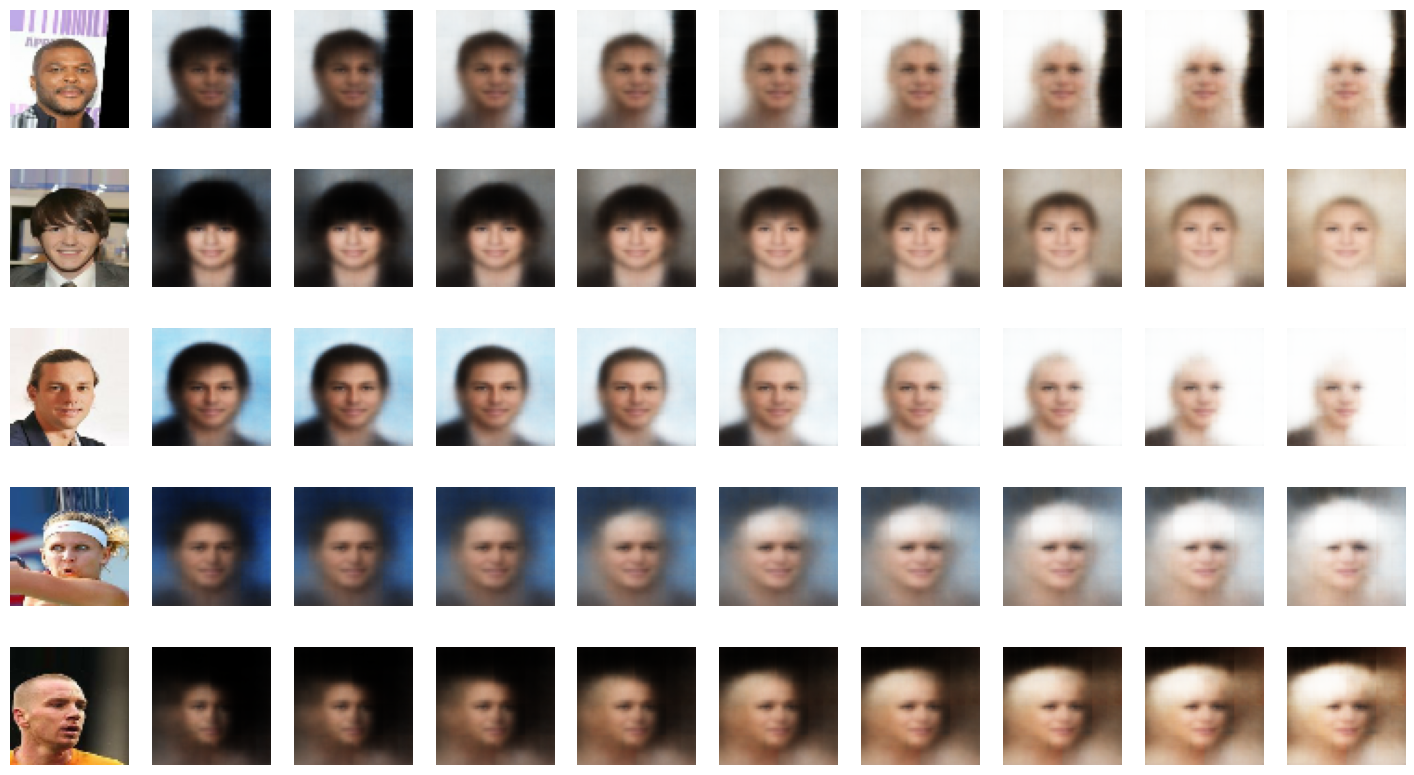

In [64]:
add_vector_to_images(labelled,vae, attribute_vec)

In [65]:
morph_faces(labelled, vae)